In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pickle

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = "\\usepackage{libertine}"
plt.rcParams["font.family"] = "Libertine"

from basic_models import predict_shift_ablation, train_nbeats_i
from data_wrangling import read_dataset, read_dataset_mts, flatten
from dataset_config import Config
from f_shapelet_utils import generate_all_f_shapelets
from SHIFT import SHIFT
from evaluation import smape
from utility import difference_list, trim_to_length
from wildboar.distance import argmin_distance

/Users/tikr7960/Library/Python/3.9/lib/python/site-packages/statsforecast/core.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/Users/tikr7960/Library/Python/3.9/lib/python/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


# Loading datasets and descriptive statistics

In [3]:
c = Config()

In [2]:
# Error metrics used for model evaluation and comparison
multivariate_dataset_names = []
error_metrics = ["smape","mase", "owa"]
algorithms = np.array(["Theta", "ARIMA", "SHIFT", "N-BEATS", "GRU", "DLinear", "TimesNet", "FEDformer", "NonStationaryT"]) 

In [3]:
datasets = []
for dataset in c.dataset_names:
    datasets.append(read_dataset(dataset, train_size=Config.train_sizes[dataset], val_size=Config.val_sizes[dataset], stride_length=Config.stride_lengths[dataset], backhorizon=Config.backhorizons[dataset], horizon=Config.horizons[dataset]))
cif = datasets[0]
nn5 = datasets[1]
tourism = datasets[2]
weather = datasets[3]
m3_m = datasets[4]
m3_q = datasets[5]
m3_y = datasets[6]
m3_o = datasets[7]
m4_h = datasets[8]
m4_w = datasets[9]
m4_y = datasets[10]

In [4]:
for d, dataset_name in zip(datasets, c.dataset_names):
    all_lengths = []
    for ts in d["ts_full"]:
        all_lengths.append(len(ts))
    print(dataset_name)
    print("Number of time series:", len(d["ts_full"]))
    print("Min length:", np.min(all_lengths))
    print("Mean length:", np.mean(all_lengths))
    print("Std length:", np.std(all_lengths))
    print("Max length:", np.max(all_lengths))
    print()

cif
Number of time series: 52
Min length: 73
Mean length: 116.5
Std length: 12.1267346102606
Max length: 120

nn5
Number of time series: 111
Min length: 791
Mean length: 791.0
Std length: 0.0
Max length: 791

tourism
Number of time series: 365
Min length: 187
Mean length: 299.14794520547946
Std length: 54.577581100590365
Max length: 333

weather
Number of time series: 18
Min length: 3654
Mean length: 3654.0
Std length: 0.0
Max length: 3654

m3_m
Number of time series: 1079
Min length: 86
Mean length: 132.7655236329935
Std length: 9.983753135572565
Max length: 144

m3_q
Number of time series: 686
Min length: 36
Mean length: 51.2201166180758
Std length: 8.158574375861173
Max length: 72

m3_y
Number of time series: 162
Min length: 36
Mean length: 44.574074074074076
Std length: 3.5115427926534637
Max length: 47

m3_o
Number of time series: 174
Min length: 71
Mean length: 76.58045977011494
Std length: 10.83427234565736
Max length: 104

m4_h
Number of time series: 414
Min length: 700
Mean le

In [100]:
datasets = []
for dataset in c.multivariate_dataset_names_short + c.multivariate_dataset_names_long:
    datasets.append(read_dataset_mts(dataset, train_size=Config.train_sizes[dataset], val_size=Config.val_sizes[dataset], stride_length=Config.stride_lengths[dataset], backhorizon=Config.backhorizons[dataset], horizon=Config.horizons[dataset]))
for d, dataset_name in zip(datasets, c.multivariate_dataset_names_short + c.multivariate_dataset_names_long):
    all_lengths = []
    for ts in d["ts_full"]:
        all_lengths.append(len(ts))
    print(dataset_name)
    print("Number of channels:", len(d["ts_full"]))
    print("Min length:", np.min(all_lengths))
    print("Mean length:", np.mean(all_lengths))
    print("Std length:", np.std(all_lengths))
    print("Max length:", np.max(all_lengths))
    print()

illness
Number of channels: 7
Min length: 966
Mean length: 966.0
Std length: 0.0
Max length: 966

exchange_rate
Number of channels: 8
Min length: 7588
Mean length: 7588.0
Std length: 0.0
Max length: 7588

ett_h1
Number of channels: 7
Min length: 17420
Mean length: 17420.0
Std length: 0.0
Max length: 17420



# Prediction errors by algorithm

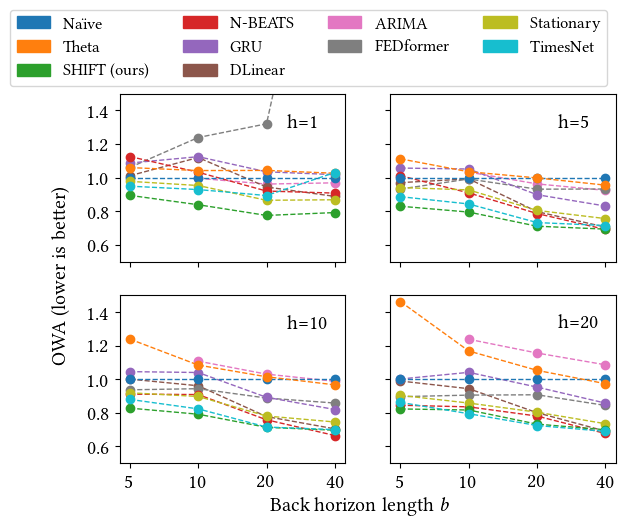

In [106]:
H = [1,5,10,20]
BH = [5,10,20,40]
methods = []
cmap = {
    "Naive": "tab:blue",
    "Theta": "tab:orange", 
    "SHIFT": "tab:green",
    "N-BEATS": "tab:red",
    "GRU": "tab:purple", 
    "DLinear": "tab:brown",
    "ARIMA": "tab:pink", 
    "FEDformer": "tab:grey", 
    "NonStationaryT": "tab:olive",
    "TimesNet": "tab:cyan",
}

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
for i, h in enumerate(H):
    ax = axs[i//2][i%2]
    error_matrix = []
    for bh in BH:
        error_row = {}
        with open(f"results/errors_h_{h}_bh_{bh}.pkl", "rb") as file:
            errors = pickle.load(file)
            for dataset, e in errors.items():
                if dataset != "m3_o":
                    for method, metrics in e.items():
                        if method not in methods:
                            methods.append(method)
                        if method in error_row:
                            error_row[method].append(metrics[-1])
                        else:
                            error_row[method] = [metrics[-1]]
        
        error_row = dict(sorted(error_row.items()))
        methods = list(error_row.keys())
        error_matrix.append(error_row)
    mean_errors = []
    for e in error_matrix:
        error_dict = {}
        for algo, errors in e.items():
            error_dict[algo] = np.mean(errors)
        mean_errors.append(error_dict)
    mean_errors[0]["ARIMA"] = None

    aggregated_mean_errors = np.array([list(e.values()) for e in mean_errors])
    for i in range(aggregated_mean_errors.shape[1]):
        ax.plot(aggregated_mean_errors[:,i], marker="o", linestyle="dashed", markersize=6, label=methods[i], linewidth=1, color=cmap[methods[i]])
    ax.set_xticks(np.arange(len(BH)), BH, fontdict={"fontsize": "x-large"})
    ax.set_yticks([0.6,0.8,1.0,1.2,1.4], [0.6,0.8,1.0,1.2,1.4], fontdict={"fontsize": "x-large"})
    ax.text(2.3,1.3,f"h={h}", size="x-large")
    ax.set_ylim(0.5,1.5)

# Rename
cmap["Stationary"] = cmap["NonStationaryT"]
del cmap["NonStationaryT"]
cmap["Naïve"] = cmap["Naive"]
del cmap["Naive"]
cmap["SHIFT (ours)"] = cmap["SHIFT"]
del cmap["SHIFT"]

sort_order = ["Naïve", "Theta", "SHIFT (ours)", "N-BEATS", "GRU", "DLinear", "ARIMA", "FEDformer", "Stationary", "TimesNet"]

patches = [mpatches.Patch(color=cmap[k], label=k) for k in sort_order]
fig.supxlabel("Back horizon length \\textit{b}", fontsize="x-large", y=0)
fig.supylabel("OWA (lower is better)", fontsize="x-large", y=0.5)

axs[0][0].legend(bbox_to_anchor=(0.1,1.35,2.1,0.2), ncol=4, handles=patches, fontsize="large");
plt.savefig(f"plots/benchmark_errors.pdf", bbox_inches="tight")

## By-sample vs global

In [6]:
with open(f"results/benchmark_by_sample.pkl", "rb") as file:
    by_sample_errors = pickle.load(file)
with open(f"results/benchmark_by_sample_global.pkl", "rb") as file:
    global_errors = pickle.load(file)
for dataset in by_sample_errors.keys():
    for algo in by_sample_errors[dataset].keys():
        print(dataset, algo, "by-sample {0:.3f}".format(by_sample_errors[dataset][algo][-1]))
        if algo != "SHIFT":
            print(dataset, algo, "global {0:.3f}".format(global_errors[dataset][algo][-1]))

m4_w SHIFT by-sample 0.970
m4_w N-BEATS by-sample 1.665
m4_w N-BEATS global 1.124
m4_w DLinear by-sample 6.760
m4_w DLinear global 1.018
nn5 SHIFT by-sample 0.515
nn5 N-BEATS by-sample 0.491
nn5 N-BEATS global 0.470
nn5 DLinear by-sample 1.061
nn5 DLinear global 0.506
m3_o SHIFT by-sample 0.859
m3_o N-BEATS by-sample 2.470
m3_o N-BEATS global 3.424
m3_o DLinear by-sample 3.693
m3_o DLinear global 1.086
m4_h SHIFT by-sample 0.381
m4_h N-BEATS by-sample 0.639
m4_h N-BEATS global 0.502
m4_h DLinear by-sample 1.748
m4_h DLinear global 0.941
tourism SHIFT by-sample 0.600
tourism N-BEATS by-sample 0.625
tourism N-BEATS global 0.550
tourism DLinear by-sample 1.159
tourism DLinear global 0.596


## Inference time

{'Naive': 1.1814746856689453, 'Theta': 6.321213483810425, 'N-BEATS': 83.34562007586162, 'GRU': 136.10981869697565, 'DLinear': 91.22988915443416, 'ARIMA': 11.573265075683594, 'TimesNet': 14062.49705562989, 'NonStationaryT': 1648.287722428639, 'FEDformer': 8969.417997598652, 'SHIFT': 246.19236660003662}


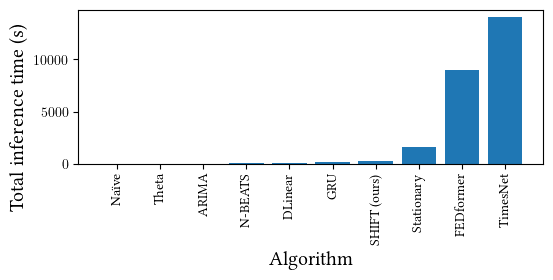

In [10]:
H = [1,5,10,20]
BH = [5,10,20,40]
columns = ["model_name", "dataset_name", "owa"]
total_times = {}
for h in H:
    for bh in BH:
        with open(f"results/inference_times_h_{h}_bh_{bh}.pkl", "rb") as file:
            times = pickle.load(file)
            for dataset, t in times.items():
                for algo, time in t.items():
                    if algo in total_times:
                        total_times[algo] += time
                    else:
                        total_times[algo] = time

total_times["SHIFT"] = 0
for h in H:
    for bh in BH:
        with open(f"results_test/inference_times_h_{h}_bh_{bh}.pkl", "rb") as file:
            times = pickle.load(file)
            for dataset, t in times.items():
                for algo, time in t.items():
                    if algo in total_times:
                        total_times[algo] += time
                    else:
                        total_times[algo] = time
print(total_times)
# Rename
total_times["Stationary"] = total_times["NonStationaryT"]
del total_times["NonStationaryT"]
total_times["Naïve"] = total_times["Naive"]
del total_times["Naive"]
total_times["SHIFT (ours)"] = total_times["SHIFT"]
del total_times["SHIFT"]

algos = np.array(list(total_times.keys()))
times = np.array(list(total_times.values()))
sort_order = np.argsort(times)
algos = algos[sort_order]
times = times[sort_order]
plt.figure(figsize=(6,2))
plt.bar(x=algos,height=times)
plt.xlabel("Algorithm",fontdict={"fontsize": "x-large"})
plt.ylabel("Total inference time (s)",fontdict={"fontsize": "x-large"}, y=0.3)
plt.xticks(rotation = 90)

plt.savefig("plots/inference_times.pdf", bbox_inches="tight")
plt.show()

# Parameter optimization

In [8]:
def grid_search(ts_raw, x, y, L=[9], N=[2], train=False):
        errors = np.full((len(L), len(N)), -1.0)

        horizon = len(y[0])
        if train:
            s = SHIFT()
            s.L = L
            s.N = N
            errors = s.optimize_hyperparameters(ts_raw, x,y)
            errors = errors[:,:,0]
        else:
            for i, l in enumerate(L):
                for j, n in enumerate(N):
                    s = SHIFT()
                    s.L = L
                    s.N = N
                    y_pred = s.fit_predict(ts_raw, x, horizon,l=l,n=n)
                    error = smape(np.array(y), np.array(y_pred))
                    errors[i, j] = error
        return errors

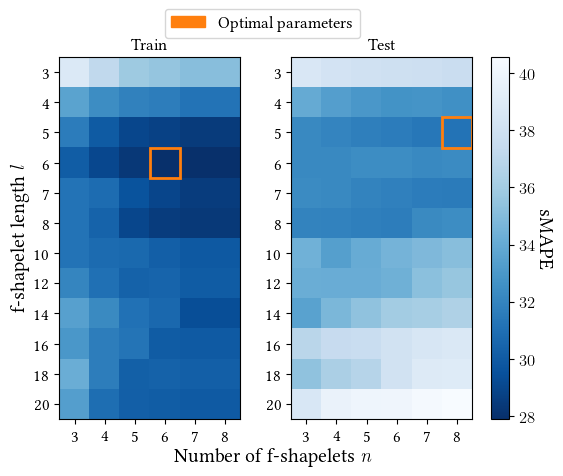

In [9]:
dataset = nn5
name = "NN5"
i = 16
test = {}
for k, v in dataset.items():
    test[k] = v[i]

N = np.arange(3,9)
L = [3,4,5,6,7,8,10,12,14,16,18,20]
L = np.array([l for l in L if l <= len(test["X_test"][0])])

error_matrix_test = grid_search(test["ts_raw"], test["X_test"], test["y_test"], L, N, train=False)

error_matrix_train = grid_search(test["ts_raw"], test["X_train"], test["y_train"], L, N, train=True)
merged = np.concatenate([error_matrix_train, error_matrix_test]).ravel()
vmin = np.min(merged)
vmax = np.max(merged)

fig, ax = plt.subplots(1,2,figsize=(6,4.7), sharex=True, sharey=False)
for i, matrix in enumerate([error_matrix_train, error_matrix_test]):
    best = divmod(matrix.argmin(), matrix.shape[1])

    def highlight_cell(x,y, ax=None, **kwargs):
        rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, **kwargs)
        ax = ax or plt.gca()
        ax.add_patch(rect)
        return rect
    
    im = ax[i].imshow(matrix, cmap="Blues_r", vmin=vmin, vmax=vmax)
    ax[i].set_xticks(np.arange(len(N)), N, fontsize="large")
    ax[i].set_yticks(np.arange(len(L)), L, fontsize="large")
    highlight_cell(best[1], best[0], ax=ax[i], color="tab:orange", linewidth=2)


orange_patch = mpatches.Patch(color="tab:orange", label="Optimal parameters")
fig.legend(bbox_to_anchor=(0.66, 1), handles=[orange_patch], fontsize="large")

ax[0].set_ylabel("f-shapelet length $\it{l}$", fontsize="x-large")
ax[0].set_title("Train")
ax[1].set_title("Test")
fig.supxlabel("Number of f-shapelets $\it{n}$", fontsize="x-large")
cbar = fig.colorbar(im, ax=ax,fraction=0.046, pad=0.04)
cbar.ax.set_ylabel("sMAPE", rotation=-90, va="bottom", fontsize="x-large", labelpad=0)
cbar.ax.tick_params(labelsize="large")

fig.savefig(f"plots/heatmap_errors_{name}.pdf",bbox_inches="tight")
plt.show()

# Outlier fallback

In [10]:
tourism_stride1 = read_dataset("tourism", train_size=Config.train_sizes["tourism"], val_size=Config.val_sizes["tourism"], stride_length=1, backhorizon=Config.backhorizons["tourism"], horizon=Config.horizons["tourism"])

outlier_usecase = {}
outlier_sample_index = 2
for k,v in tourism_stride1.items():
    outlier_usecase[k] = [v[outlier_sample_index]]
y_pred_no_fallback, _ = predict_shift_ablation(outlier_usecase,k=False,z_normalization=False)
y_pred, _ = predict_shift_ablation(outlier_usecase,k=1,z_normalization=False)

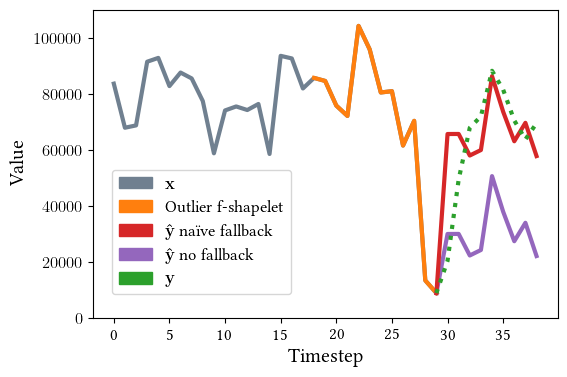

In [11]:
train_length = int(len(tourism_stride1["ts_full"][outlier_sample_index]) * 0.8)
testset = tourism_stride1["ts_full"][outlier_sample_index][train_length-24:][:54]

fig, axs = plt.subplots(1, 1)

fig.set_figwidth(6)
fig.set_figheight(4)

shift = 4
# axs.plot(testset)
true = np.concatenate([outlier_usecase["X_test"][0][shift][-1:], outlier_usecase["y_test"][0][shift][:9]])
pred = np.concatenate([outlier_usecase["X_test"][0][shift][-1:], y_pred_no_fallback[0][shift][:9]])
pred_no_fallback = np.concatenate([outlier_usecase["X_test"][0][shift][-1:], y_pred[0][shift][:9]])

shapelet_length = 12

axs.plot(np.arange(len(outlier_usecase["X_test"][0][shift]))+shift, outlier_usecase["X_test"][0][shift], color="slategray", linewidth=3)
axs.plot(np.arange(len(outlier_usecase["X_test"][0][shift][-shapelet_length:]))+shift+len(outlier_usecase["X_test"][0][shift])-shapelet_length, outlier_usecase["X_test"][0][shift][-shapelet_length:], color="tab:orange", linewidth=3)
axs.plot(np.arange(10)+33, pred, color="tab:purple", linewidth=3)
axs.plot(np.arange(10)+33, pred_no_fallback, color="tab:red", linewidth=3)
axs.plot(np.arange(10)+33, true, color="tab:green", linestyle="dotted", linewidth=3)

axs.set_xlabel("Timestep", fontdict={"fontsize": "x-large"})
axs.set_ylabel("Value", fontdict={"fontsize": "x-large"})

axs.set_xticks(np.arange(len(pred)+len(outlier_usecase["X_test"][0][shift]))+4,np.arange(len(pred)+len(outlier_usecase["X_test"][0][shift])), fontsize="large")
plt.yticks(fontsize="large")
axs.locator_params(nbins=9, axis="x")
axs.set_ylim(0,110000)

gray_patch = mpatches.Patch(color="slategray", label="$\mathbf{x}$")
orange_patch = mpatches.Patch(color="tab:orange", label="Outlier f-shapelet")
red_patch = mpatches.Patch(color="tab:red", label="$\mathbf{\hat{y}}$ naïve fallback")
purple_patch = mpatches.Patch(color="tab:purple", label="$\mathbf{\hat{y}}$ no fallback")
green_patch = mpatches.Patch(color="tab:green", label="$\mathbf{y}$")

fig.legend(bbox_to_anchor=(0,0.5,0.47,0), ncol=1, labelspacing=0.5, handles=[gray_patch, orange_patch, red_patch, purple_patch, green_patch], fontsize="large")
plt.savefig("plots/outlier_fallback_use_case.pdf", bbox_inches="tight");

# Chaining

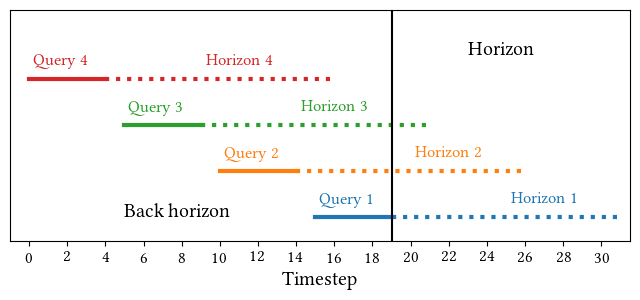

In [12]:
l = 5
h = 13
shapelet1 = np.full(l, 0)
horizon1 = np.full(h, 0)
shapelet2 = np.full(l, 1)
horizon2 = np.full(h, 1)
shapelet3 = np.full(l, 2)
horizon3 = np.full(h, 2)
shapelet4 = np.full(l, 3)
horizon4 = np.full(h, 3)
plt.figure(figsize=(8,3))
plt.plot(np.arange(l)+ 3*l, shapelet1, color="tab:blue", linewidth=3)
plt.plot(np.arange(h)+ 4*l-1, horizon1, color="tab:blue", linestyle="dotted", linewidth=3)
plt.text(3*l+0.2, 0.3, "Query 1", color="tab:blue", fontsize="large")
plt.text(3*l+0.5+0.75*h, 0.3, "Horizon 1", color="tab:blue", fontsize="large")
plt.plot(np.arange(l)+ 2*l, shapelet2, color="tab:orange", linewidth=3)
plt.plot(np.arange(h)+ 3*l-1, horizon2, color="tab:orange", linestyle="dotted", linewidth=3)
plt.text(2*l+0.2, 1.3, "Query 2", color="tab:orange", fontsize="large")
plt.text(2*l+0.5+0.75*h, 1.3, "Horizon 2", color="tab:orange", fontsize="large")
plt.plot(np.arange(l)+ l, shapelet3, color="tab:green", linewidth=3)
plt.plot(np.arange(h)+ 2*l-1, horizon3, color="tab:green", linestyle="dotted", linewidth=3)
plt.text(1*l+0.2, 2.3, "Query 3", color="tab:green", fontsize="large")
plt.text(1*l-0.5+0.75*h, 2.3, "Horizon 3", color="tab:green", fontsize="large")
plt.plot(np.arange(l), shapelet4, color="tab:red", linewidth=3)
plt.plot(np.arange(h)+ l-1, horizon4, color="tab:red", linestyle="dotted", linewidth=3)
plt.text(0*l+0.2, 3.3, "Query 4", color="tab:red", fontsize="large")
plt.text(0*l-0.5+0.75*h, 3.3, "Horizon 4", color="tab:red", fontsize="large")
plt.axvline(4*l-1, color="black")
plt.text(5,0, "Back horizon", fontdict={"fontsize":"x-large"})
plt.text(23,3.5, "Horizon", fontdict={"fontsize":"x-large"})
plt.ylim(-0.5,4.5)
plt.yticks([],[])
plt.xlabel("Timestep", fontdict={"fontsize": "x-large"})
plt.xlim(-1,31.5)
plt.xticks(np.arange(4*l-1+h),np.arange(4*l-1+h), fontsize="large")
plt.locator_params(axis="x", nbins=4*l-1+h//2)
plt.savefig("plots/chaining_temporal_order.pdf", bbox_inches="tight")

# Forecasting use case

In [13]:
usecase = {}
i = 4
shift = 0
for k,v  in m4_h.items():
    usecase[k] = v[i]

In [14]:
s = SHIFT()
errors = s.optimize_hyperparameters(usecase["ts_raw"],usecase["X_train"],usecase["y_train"])
y_pred = s.fit_predict(usecase["ts_raw"],usecase["X_test"],h=len(usecase["y_train"][0]))

In [15]:
from matplotlib.collections import PatchCollection

# define an object that will be used by the legend
class MulticolorPatch(object):
    def __init__(self, colors):
        self.colors = colors

# define a handler for the MulticolorPatch object
class MulticolorPatchHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        width, height = handlebox.width, handlebox.height
        patches = []
        for i, c in enumerate(orig_handle.colors):
            patches.append(plt.Rectangle([width/len(orig_handle.colors) * i - handlebox.xdescent, 
                                          -handlebox.ydescent],
                           (width / len(orig_handle.colors))+1,
                           height, 
                           facecolor=c, 
                           edgecolor='none'))

        patch = PatchCollection(patches,match_original=True)

        handlebox.add_artist(patch)
        return patch

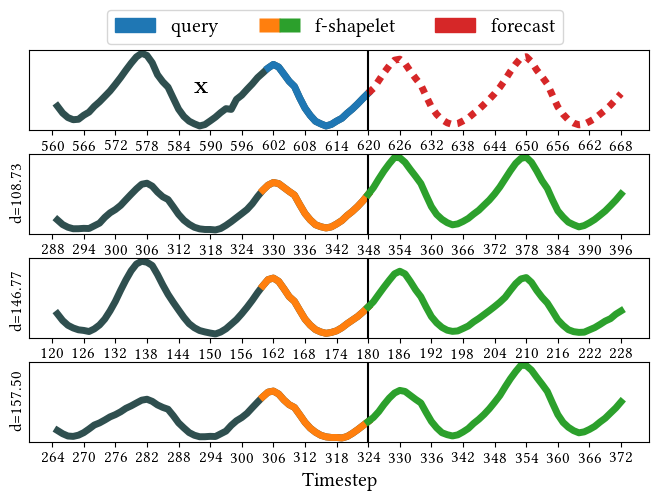

In [16]:
l = s._optimal_l
n = s._optimal_n

b = len(usecase["X_test"][shift])
h = len(usecase["y_test"][shift])

fig, ax = plt.subplots(4,1, figsize=(8,4))

shapelets, shapelet_horizons = generate_all_f_shapelets(usecase["ts_raw"], l,h, z_normalization=False)
X_test_trimmed = trim_to_length(usecase["X_test"], l)
x_differenced = difference_list(X_test_trimmed[shift])
similar_shapelets, distances = argmin_distance(x_differenced, shapelets, k=3, metric="euclidean", sorted=True, return_distance=True)
similar_shapelets = similar_shapelets[0]
distances = distances[0]

shap = shapelets[similar_shapelets]
for i, index, shapelet in zip(np.arange(len(similar_shapelets)), similar_shapelets, shap):
    shap_absolute = np.cumsum(shapelet) + usecase["ts_raw"][index]
    s_concat = np.concatenate([usecase["ts_raw"][index-1:index+1], shap_absolute])
    neg_index = index - (b-l)
    ax[i+1].plot(np.arange(b)+1, usecase["ts_raw"][neg_index:index+l], color="darkslategray", linewidth=5)
    ax[i+1].plot(np.arange(l+1)+b-l, s_concat, color="tab:orange", linewidth=5)
    ax[i+1].axvline(b, color="black")

    ax[i+1].plot(np.arange(h+1)+b, usecase["ts_raw"][index+l-1:index+l+h], color="tab:green", linewidth=5)
    ax[i+1].set_xticks(np.arange(h+b+1))
    ax[i+1].set_xticklabels(np.arange(h+b+1) + similar_shapelets[i], fontsize="large")
    ax[i+1].locator_params(axis="x", nbins=(h+b)//5)

    ax[i+1].text(-8,1700, "d={0:.2f}".format(distances[i]), fontsize="large", rotation=90)

pred = np.concatenate([usecase["X_test"][shift][-1:], y_pred[shift]])
ax[0].plot(np.arange(b)+1, usecase["X_test"][shift], color="darkslategray", linewidth=5)
shapelet = usecase["X_test"][shift][-l:]
ax[0].plot(np.arange(l)+1+b-l, shapelet+0*np.mean(shapelet), color="tab:blue", linewidth=5)
ax[0].plot(np.arange(h+1)+b, pred, color="tab:red", linestyle=(0,(1,1)), linewidth=5)
ax[0].axvline(b, color="black")
ax[0].set_xticks(np.arange(h+b+1))
ax[0].set_xticklabels(np.arange(h+b+1) + len(usecase["ts_raw"]), fontsize="large")
ax[0].text(0.45*b,2200,"$\mathbf{x}$", fontsize="xx-large")
ax[0].locator_params(axis="x", nbins=(h+b)//5)
for a in ax:
    a.set_yticks([])
plt.xlabel("Timestep", fontdict={"fontsize": "x-large"})
fig.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.3, wspace=0.4)


blue_patch = mpatches.Patch(color="tab:blue")
orange_green_patch = MulticolorPatch(["tab:orange","tab:green"])
red_patch = mpatches.Patch(color="tab:red")

ax[0].legend(bbox_to_anchor=(0.11,0.94,0.7,0.2), 
             ncol=4, 
             handles=[blue_patch, orange_green_patch, red_patch], 
             labels=["query", "f-shapelet", "forecast"], 
             handler_map={MulticolorPatch: MulticolorPatchHandler()}, 
             fontsize="x-large");

plt.savefig("plots/f-shapelet_aggregation.pdf", bbox_inches="tight")

# Interpretability

In [17]:
def find_closest_f_shapelets(x, f_shapelets, n, metric):
    return argmin_distance(x, f_shapelets, k=n, metric=metric, sorted=True, return_distance=True)

h = 5
b = 20
l = 20
n = 6
sample_index = 43
instance_index = 88
transactions = read_dataset("transactions", 0.6, 0.2, 1, b, h)
transactions_flat, original_shapes = flatten(transactions)

# Using non-differenced shapelets for this example for better visual clarity
all_f_shapelets, all_f_shapelet_horizons = generate_all_f_shapelets(transactions["ts_raw"][sample_index], l, h, stride_length=1, differencing=False)
current_f_shapelet = transactions["X_test"][sample_index][instance_index][-l:]

# Find the closest n f-shapelets to the current shapelet
f_shapelets = np.array(all_f_shapelets)
best_f_shapelet_indices, best_f_shapelet_distances = find_closest_f_shapelets(current_f_shapelet, f_shapelets, n, metric="dtw")
best_f_shapelet_indices = best_f_shapelet_indices[0]
best_f_shapelet_distances = best_f_shapelet_distances[0]

# Remove overlapping similar shapelets for visual clarity
retained_indices = []
retained_distances = []
threshold = 10
for i, d  in zip(best_f_shapelet_indices, best_f_shapelet_distances):
    retain = True
    for r in retained_indices:
        if abs(r-i) < threshold:
            retain = False
    if retain:
        retained_indices.append(i)
        retained_distances.append(d)
sort_order = np.argsort(retained_indices)
retained_indices = np.array(retained_indices)[sort_order]
retained_distances = np.array(retained_distances)[sort_order]

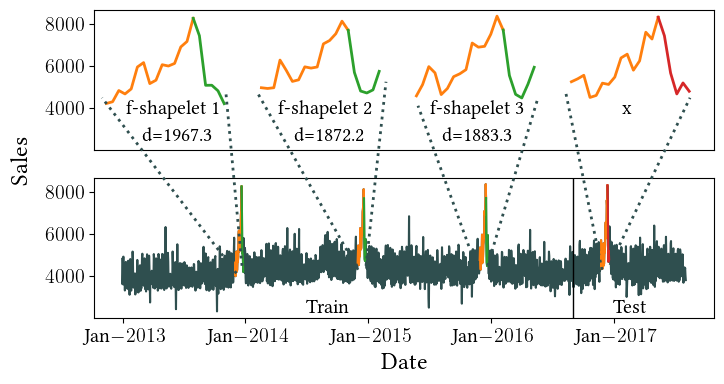

In [18]:
import matplotlib.dates as mdates
import matplotlib.lines as lines

length = len(transactions["ts_full"][sample_index])
offset = 365.25*43
first_shapelet_offset = retained_indices[0]
second_shapelet_offset = retained_indices[1]
third_shapelet_offset = retained_indices[2]

x_shapelet_offset =  329+365*3

fig, ax = plt.subplots(nrows = 2, ncols = 1,figsize=(8,4), sharey=True)

ax[0].plot(np.arange(l-h)+2, transactions["ts_full"][sample_index][first_shapelet_offset+5:first_shapelet_offset+l], lw=2, color="tab:orange")
ax[0].plot(np.arange(h+1)+16, transactions["ts_full"][sample_index][first_shapelet_offset+l-1:first_shapelet_offset+l+h], lw=2, color="tab:green")
ax[0].plot(np.arange(l-h)+27, transactions["ts_full"][sample_index][second_shapelet_offset+5:second_shapelet_offset+l], lw=2, color="tab:orange")
ax[0].plot(np.arange(h+1)+41, transactions["ts_full"][sample_index][second_shapelet_offset+l-1:second_shapelet_offset+l+h], lw=2, color="tab:green")
ax[0].plot(np.arange(l-h)+52, transactions["ts_full"][sample_index][third_shapelet_offset+5:third_shapelet_offset+l], lw=2, color="tab:orange")
ax[0].plot(np.arange(h+1)+66, transactions["ts_full"][sample_index][third_shapelet_offset+l-1:third_shapelet_offset+l+h], lw=2, color="tab:green")
ax[0].plot(np.arange(l-h)+77, transactions["ts_full"][sample_index][x_shapelet_offset+5:x_shapelet_offset+l], lw=2, color="tab:orange")
ax[0].plot(np.arange(h+1)+91, transactions["ts_full"][sample_index][x_shapelet_offset+l-1:x_shapelet_offset+l+h], lw=2, color="tab:red")
ax[0].set_xlim(0,100)
ax[0].set_xticklabels([])
ax[0].set_xticks([]);

ax[1].plot(np.arange(length)+offset, transactions["ts_full"][sample_index], color="darkslategray")
ax[1].plot(np.arange(l)+offset+first_shapelet_offset, transactions["ts_full"][sample_index][first_shapelet_offset:first_shapelet_offset+l], color="tab:orange")
ax[1].plot(np.arange(h+1)+offset+first_shapelet_offset+l-1, transactions["ts_full"][sample_index][first_shapelet_offset+l-1:first_shapelet_offset+l+h], color="tab:green")
ax[1].plot(np.arange(l)+offset+second_shapelet_offset, transactions["ts_full"][sample_index][second_shapelet_offset:second_shapelet_offset+l], color="tab:orange")
ax[1].plot(np.arange(h+1)+offset+second_shapelet_offset+l-1, transactions["ts_full"][sample_index][second_shapelet_offset+l-1:second_shapelet_offset+l+h], color="tab:green")
ax[1].plot(np.arange(l)+offset+third_shapelet_offset, transactions["ts_full"][sample_index][third_shapelet_offset:third_shapelet_offset+l], color="tab:orange")
ax[1].plot(np.arange(h+1)+offset+third_shapelet_offset+l-1, transactions["ts_full"][sample_index][third_shapelet_offset+l-1:third_shapelet_offset+l+h], color="tab:green")
ax[1].plot(np.arange(l)+offset+x_shapelet_offset, transactions["ts_full"][sample_index][x_shapelet_offset:x_shapelet_offset+l], color="tab:orange")
plt.plot(np.arange(h+1)+offset+x_shapelet_offset+l-1, transactions["ts_full"][sample_index][x_shapelet_offset+l-1:x_shapelet_offset+l+h], color="tab:red")
ax[1].axvline(offset + 0.8*length, color="black", lw=1)
ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))
ax[1].xaxis.set_major_locator(mdates.DayLocator(interval=365))
xticks = np.arange(5) * 365 + offset + 1
xticks[-1] += 1
ax[1].set_xticks(xticks)
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontdict={"fontsize": "x-large"})
ax[1].set_xlabel("Date", fontdict={"fontsize": "xx-large"})

ax[0].set_yticks(ax[0].get_yticks()[1:-1], ax[0].get_yticklabels()[1:-1], fontdict={"fontsize": "x-large"})
ax[1].set_yticks(ax[1].get_yticks(), ax[1].get_yticklabels(), fontdict={"fontsize": "x-large"})

ax[1].text(offset + 365*1.5,2300, "Train", fontdict={"fontsize": "x-large"})
ax[1].text(offset + 365*4,2300, "Test", fontdict={"fontsize": "x-large"})

fig.supylabel("Sales", fontsize="xx-large")

fig.add_artist(lines.Line2D([0.303, 0.135], [0.221, 0.66], color="darkslategray",linestyle="dotted", lw=2))
fig.add_artist(lines.Line2D([0.31, 0.29], [0.24, 0.67], color="darkslategray",linestyle="dotted", lw=2))

fig.add_artist(lines.Line2D([0.455, 0.33], [0.23, 0.67], color="darkslategray",linestyle="dotted", lw=2))
fig.add_artist(lines.Line2D([0.465, 0.49], [0.24, 0.7], color="darkslategray",linestyle="dotted", lw=2))

fig.add_artist(lines.Line2D([0.606, 0.53], [0.22, 0.64], color="darkslategray",linestyle="dotted", lw=2))
fig.add_artist(lines.Line2D([0.617, 0.68], [0.24, 0.66], color="darkslategray",linestyle="dotted", lw=2))

fig.add_artist(lines.Line2D([0.76, 0.715], [0.23, 0.67], color="darkslategray",linestyle="dotted", lw=2))
fig.add_artist(lines.Line2D([0.77, 0.87], [0.242, 0.66], color="darkslategray",linestyle="dotted", lw=2))

fig.text(0.165,0.62,"f-shapelet 1", fontdict={"fontsize": "x-large"})
fig.text(0.355,0.62,"f-shapelet 2", fontdict={"fontsize": "x-large"})
fig.text(0.545,0.62,"f-shapelet 3", fontdict={"fontsize": "x-large"})

fig.text(0.185,0.55, "d={0:.1f}".format(retained_distances[0]), fontdict={"fontsize": "x-large"})
fig.text(0.375,0.55, "d={0:.1f}".format(retained_distances[1]), fontdict={"fontsize": "x-large"})
fig.text(0.56,0.55, "d={0:.1f}".format(retained_distances[2]), fontdict={"fontsize": "x-large"})

fig.text(0.785,0.62,"x", fontdict={"fontsize": "x-large"})

fig.savefig("plots/interpretability_sample.pdf", bbox_inches="tight")

## Interpretability plot with N-BEATS

In [19]:
nbeats_i = train_nbeats_i(transactions_flat["X_train"],transactions_flat["y_train"],transactions_flat["X_val"],transactions_flat["y_val"], 0)

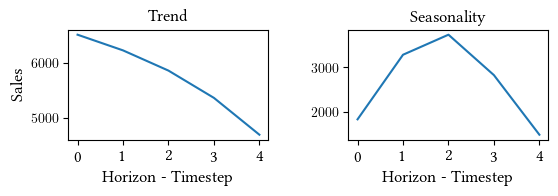

In [20]:
nbeats_i.enable_intermediate_outputs()
nbeats_i.predict(np.array([transactions["X_test"][sample_index][instance_index]]),verbose=0)
g_pred, i_pred, outputs = nbeats_i.get_generic_and_interpretable_outputs()


a = list(outputs.values())
trend_blocks = a[:nbeats_i.nb_blocks_per_stack]
trend_sum = np.sum(trend_blocks, axis=0)
seasonality_blocks = a[nbeats_i.nb_blocks_per_stack:]
seasonality_sum = np.sum(seasonality_blocks, axis=0)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 2))
plt.subplots_adjust(left=0.1, bottom=0.2, right=0.9, top=0.75, wspace=0.4, hspace=0.4)
axes[0].plot(trend_sum, color="tab:blue")
axes[0].set_title("Trend")
axes[0].set_xlabel("Horizon - Timestep", fontsize="large")
axes[0].set_ylabel("Sales", fontsize="large")
axes[0].set_xticks(np.arange(5), np.arange(5), fontsize="large")

axes[1].plot(seasonality_sum, color="tab:blue")
axes[1].set_title("Seasonality")
axes[1].set_xlabel("Horizon - Timestep", fontsize="large")
axes[1].set_xticks(np.arange(5), np.arange(5), fontsize="large")
plt.savefig("plots/nbeats_interpretability.pdf", bbox_inches="tight")
plt.show()

# Interpretability 2

In [21]:
def find_closest_f_shapelets(x, f_shapelets, n, metric):
    return argmin_distance(x, f_shapelets, k=n, metric=metric, sorted=True, return_distance=True)

h = 5
b = 20
l = 15
n = 3
sample_index = 0
instance_index = 5
tourism = read_dataset("tourism", 0.6, 0.2, 1, b, h)
tourism_flat, original_shapes = flatten(tourism)

all_f_shapelets, all_f_shapelet_horizons = generate_all_f_shapelets(tourism["ts_raw"][sample_index], l, h, stride_length=1)
current_f_shapelet = tourism["X_test"][sample_index][instance_index][-l:]
current_f_shapelet = difference_list(current_f_shapelet)

# Find the closest n f-shapelets to the current shapelet
f_shapelets = np.array(all_f_shapelets)
best_f_shapelet_indices, best_f_shapelet_distances = find_closest_f_shapelets(current_f_shapelet, f_shapelets, n, metric="dtw")
best_f_shapelet_indices = best_f_shapelet_indices[0]
best_f_shapelet_distances = best_f_shapelet_distances[0]

# Remove overlapping similar shapelets for visual clarity
retained_indices = []
retained_distances = []
threshold = 10
for i, d  in zip(best_f_shapelet_indices, best_f_shapelet_distances):
    retain = True
    for r in retained_indices:
        if abs(r-i) < threshold:
            retain = False
    if retain:
        retained_indices.append(i)
        retained_distances.append(d)
sort_order = np.argsort(retained_indices)
retained_indices = np.array(retained_indices)[sort_order]
retained_distances = np.array(retained_distances)[sort_order]

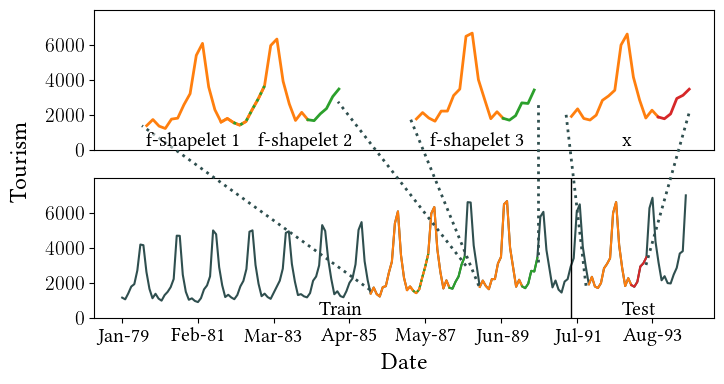

In [22]:
import matplotlib.dates as mdates
import matplotlib.lines as lines

length = len(tourism["ts_full"][sample_index])
first_shapelet_offset = retained_indices[0]
second_shapelet_offset = retained_indices[1]
third_shapelet_offset = retained_indices[2]

ticks = 8
dates = pd.date_range("1979-01-01","1994-07-01", freq="MS").strftime("%b-%y").tolist()
# dates = np.array(dates)[np.arange(ticks)*int(len(dates)/ticks)]
# dates = np.concatenate([["0"],dates])

x_shapelet_offset = len(tourism["ts_raw"][sample_index]) + 5

fig, ax = plt.subplots(nrows = 2, ncols = 1,figsize=(8,4), sharey=True)

ax[0].plot(np.arange(l)+2+6.5, tourism["ts_full"][sample_index][first_shapelet_offset:first_shapelet_offset+l], lw=2, color="tab:orange")
ax[0].plot(np.arange(l)+27-6.5, tourism["ts_full"][sample_index][second_shapelet_offset:second_shapelet_offset+l], lw=2, color="tab:orange")
ax[0].plot(np.arange(h+1)+16+6.5, tourism["ts_full"][sample_index][first_shapelet_offset+l-1:first_shapelet_offset+l+h], lw=2, linestyle="dotted", gapcolor="tab:orange", color="tab:green")
ax[0].plot(np.arange(h+1)+41-6.5, tourism["ts_full"][sample_index][second_shapelet_offset+l-1:second_shapelet_offset+l+h], lw=2, color="tab:green")

ax[0].plot(np.arange(l)+52, tourism["ts_full"][sample_index][third_shapelet_offset:third_shapelet_offset+l], lw=2, color="tab:orange")
ax[0].plot(np.arange(h+1)+66, tourism["ts_full"][sample_index][third_shapelet_offset+l-1:third_shapelet_offset+l+h], lw=2, color="tab:green")
ax[0].plot(np.arange(l)+77, tourism["ts_full"][sample_index][x_shapelet_offset:x_shapelet_offset+l], lw=2, color="tab:orange")
ax[0].plot(np.arange(h+1)+91, tourism["ts_full"][sample_index][x_shapelet_offset+l-1:x_shapelet_offset+l+h], lw=2, color="tab:red")
ax[0].set_xlim(0,100)
ax[0].set_xticklabels([])
ax[0].set_xticks([]);

ax[1].plot(np.arange(length), tourism["ts_full"][sample_index], color="darkslategray")
ax[1].plot(np.arange(l)+first_shapelet_offset, tourism["ts_full"][sample_index][first_shapelet_offset:first_shapelet_offset+l], color="tab:orange")
ax[1].plot(np.arange(l)+second_shapelet_offset, tourism["ts_full"][sample_index][second_shapelet_offset:second_shapelet_offset+l], color="tab:orange")
ax[1].plot(np.arange(l)+third_shapelet_offset, tourism["ts_full"][sample_index][third_shapelet_offset:third_shapelet_offset+l], color="tab:orange")
ax[1].plot(np.arange(h+1)+first_shapelet_offset+l-1, tourism["ts_full"][sample_index][first_shapelet_offset+l-1:first_shapelet_offset+l+h], linestyle="dotted", gapcolor="tab:orange", color="tab:green")
ax[1].plot(np.arange(h+1)+second_shapelet_offset+l-1, tourism["ts_full"][sample_index][second_shapelet_offset+l-1:second_shapelet_offset+l+h], color="tab:green")
ax[1].plot(np.arange(h+1)+third_shapelet_offset+l-1, tourism["ts_full"][sample_index][third_shapelet_offset+l-1:third_shapelet_offset+l+h], color="tab:green")
ax[1].plot(np.arange(l)+x_shapelet_offset, tourism["ts_full"][sample_index][x_shapelet_offset:x_shapelet_offset+l], color="tab:orange")
plt.plot(np.arange(h+1)+x_shapelet_offset+l-1, tourism["ts_full"][sample_index][x_shapelet_offset+l-1:x_shapelet_offset+l+h], color="tab:red")
ax[1].axvline(np.floor(0.8*length)-1, color="black", lw=1)

# We don't care about tick [0] and [-1] since they are not visible
ticks = ax[1].get_xticks()[1:-1]
dates = [dates[int(tick)] for tick in ticks]
ax[1].set_xticks(ticks)
ax[1].set_xticklabels(dates, fontdict={"fontsize": "x-large"})
ax[1].set_xlabel("Date", fontdict={"fontsize": "xx-large"})

ax[0].set_yticks(ax[0].get_yticks()[:-1], ax[0].get_yticklabels()[:-1], fontdict={"fontsize": "x-large"})
ax[1].set_yticks(ax[1].get_yticks(), ax[1].get_yticklabels(), fontdict={"fontsize": "x-large"})

ax[1].text(65,200, "Train", fontdict={"fontsize": "x-large"})
ax[1].text(165,200, "Test", fontdict={"fontsize": "x-large"})
ax[1].set_ylim(0,8000)

fig.supylabel("Tourism", fontsize="xx-large")

fig.add_artist(lines.Line2D([0.47, 0.185], [0.18, 0.59], color="darkslategray",linestyle="dotted", lw=2))
fig.add_artist(lines.Line2D([0.590, 0.43], [0.24, 0.65], color="darkslategray",linestyle="dotted", lw=2))

fig.add_artist(lines.Line2D([0.606, 0.52], [0.19, 0.61], color="darkslategray",linestyle="dotted", lw=2))
fig.add_artist(lines.Line2D([0.68, 0.68], [0.25, 0.65], color="darkslategray",linestyle="dotted", lw=2))

fig.add_artist(lines.Line2D([0.74, 0.715], [0.19, 0.62], color="darkslategray",linestyle="dotted", lw=2))
fig.add_artist(lines.Line2D([0.815, 0.87], [0.242, 0.63], color="darkslategray",linestyle="dotted", lw=2))

fig.text(0.19, 0.54, "f-shapelet 1", fontsize="x-large", bbox=dict(facecolor="white", alpha=0.5, linewidth=0, pad=0))

fig.text(0.33,0.54,"f-shapelet 2", fontdict={"fontsize": "x-large"})
fig.text(0.545,0.54,"f-shapelet 3", fontdict={"fontsize": "x-large"})

fig.text(0.785,0.54,"x", fontdict={"fontsize": "x-large"})

fig.savefig("plots/interpretability_sample2.pdf", bbox_inches="tight")

In [23]:
nbeats_i = train_nbeats_i(tourism_flat["X_train"],tourism_flat["y_train"],tourism_flat["X_val"],tourism_flat["y_val"], 0)

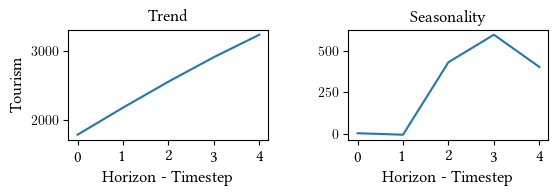

In [24]:
nbeats_i.enable_intermediate_outputs()
nbeats_i.predict(np.array([tourism["X_test"][sample_index][instance_index]]),verbose=0)
g_pred, i_pred, outputs = nbeats_i.get_generic_and_interpretable_outputs()

a = list(outputs.values())
trend_blocks = a[:nbeats_i.nb_blocks_per_stack]
trend_sum = np.sum(trend_blocks, axis=0)
seasonality_blocks = a[nbeats_i.nb_blocks_per_stack:]
seasonality_sum = np.sum(seasonality_blocks, axis=0)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 2))
plt.subplots_adjust(left=0.1, bottom=0.2, right=0.9, top=0.75, wspace=0.4, hspace=0.4)
axes[0].plot(trend_sum, color="tab:blue")
axes[0].set_title("Trend")
axes[0].set_xlabel("Horizon - Timestep", fontsize="large")
axes[0].set_ylabel("Tourism", fontsize="large")
axes[0].set_xticks(np.arange(5), np.arange(5), fontsize="large")

axes[1].plot(seasonality_sum, color="tab:blue")
axes[1].set_title("Seasonality")
axes[1].set_xlabel("Horizon - Timestep", fontsize="large")
axes[1].set_xticks(np.arange(5), np.arange(5), fontsize="large")
plt.savefig("plots/nbeats_interpretability2.pdf", bbox_inches="tight")
plt.show()

# Ablation studies

In [25]:
with open("results/benchmark_base.pkl", "rb") as file:
    errors = pickle.load(file)
error_df = pd.DataFrame(columns=["SHIFT"])

for dataset, e in errors.items():
    for method, metrics in e.items():
        error_df.loc[dataset, method] = metrics[-1]

error_df

,SHIFT
nn5,0.528598
tourism,0.60479
weather,0.974065
m4_h,0.24707
m4_w,0.894711
m4_y,1.044925
transactions,0.610174


          nn5   tourism   weather      m4_h      m4_w      m4_y  transactions
0    0.590650  0.604781  1.014096  0.264857  0.972738  1.016595      0.655789
1    0.591265  0.620373  1.014096  0.265137  0.971329  1.015902      0.656881
2    0.592098  0.635775  1.014096  0.265337  0.970666  1.015785      0.657518
Off  0.592357  0.671452  1.014096  0.266231  0.958166  1.010663      0.657862


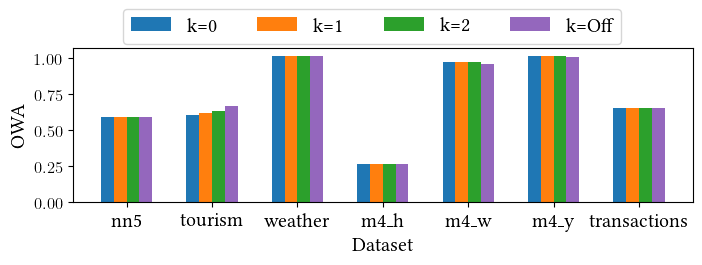

In [26]:
with open("results/ablation_k_nbeats.pkl", "rb") as file:
    errors = pickle.load(file)

e_k_0 = errors["SHIFT_k=0"]
e_k_1 = errors["SHIFT_k=1"]
e_k_2 = errors["SHIFT_k=2"]
e_k_off = errors["SHIFT_k=False"]
error_df = pd.DataFrame(columns=list(e_k_0.keys()))

error_df.loc["0"] = np.array(list(e_k_0.values()))[:,-1]
error_df.loc["1"] = np.array(list(e_k_1.values()))[:,-1]
error_df.loc["2"] = np.array(list(e_k_2.values()))[:,-1]
error_df.loc["Off"] = np.array(list(e_k_off.values()))[:,-1]

r = np.arange(len(error_df.columns)) 
width = 0.15

plt.figure(figsize=(8,2))
plt.bar(r-(width*1.5), error_df.loc["0"], color = "tab:blue", 
        width = width, label="k=0") 
plt.bar(r-(width*0.5), error_df.loc["1"], color = "tab:orange", 
        width = width, label="k=1") 
plt.bar(r+(width*0.5), error_df.loc["2"], color = "tab:green", 
        width = width, label="k=2") 
plt.bar(r+(width*1.5), error_df.loc["Off"], color = "tab:purple", 
        width = width, label="k=Off") 
plt.xticks(r,error_df.columns, fontsize="x-large")
plt.yticks(fontsize="large")
plt.legend(bbox_to_anchor=(0.07,1.12,0.83,0.2), ncol=4, fontsize="x-large")
plt.xlabel("Dataset", fontdict={"fontsize": "x-large"})
plt.ylabel("OWA", fontdict={"fontsize": "x-large"})
# plt.savefig("plots/ablation_outlier_fallback_nbeats.pdf", bbox_inches="tight")

print(error_df)

          nn5   tourism   weather      m4_h      m4_w      m4_y  transactions
0    0.592033  0.682469  1.014096  0.347243  0.983967  1.016240      0.657841
1    0.591877  0.674195  1.014096  0.316199  0.979669  1.015172      0.657872
2    0.592134  0.674604  1.014096  0.296401  0.978635  1.014370      0.658086
Off  0.592357  0.671452  1.014096  0.266231  0.958166  1.010663      0.657862


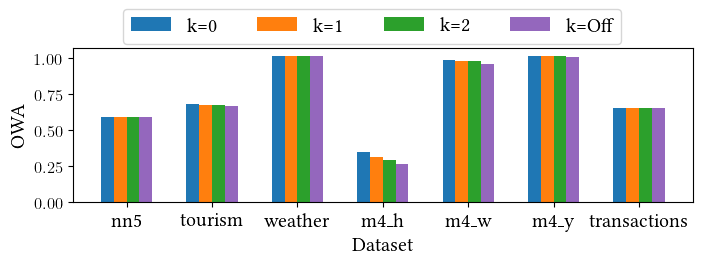

In [27]:
with open("results/ablation_k_naive.pkl", "rb") as file:
    errors = pickle.load(file)
errors

e_k_0 = errors["SHIFT_k=0"]
e_k_1 = errors["SHIFT_k=1"]
e_k_2 = errors["SHIFT_k=2"]
e_k_off = errors["SHIFT_k=False"]
error_df = pd.DataFrame(columns=list(e_k_0.keys()))

error_df.loc["0"] = np.array(list(e_k_0.values()))[:,-1]
error_df.loc["1"] = np.array(list(e_k_1.values()))[:,-1]
error_df.loc["2"] = np.array(list(e_k_2.values()))[:,-1]
error_df.loc["Off"] = np.array(list(e_k_off.values()))[:,-1]

r = np.arange(len(error_df.columns)) 
width = 0.15

plt.figure(figsize=(8,2))
plt.bar(r-(width*1.5), error_df.loc["0"], color = "tab:blue", 
        width = width, label="k=0") 
plt.bar(r-(width*0.5), error_df.loc["1"], color = "tab:orange", 
        width = width, label="k=1") 
plt.bar(r+(width*0.5), error_df.loc["2"], color = "tab:green", 
        width = width, label="k=2") 
plt.bar(r+(width*1.5), error_df.loc["Off"], color = "tab:purple", 
        width = width, label="k=Off") 
plt.xticks(r,error_df.columns, fontsize="x-large")
plt.yticks(fontsize="large")
plt.legend(bbox_to_anchor=(0.07,1.12,0.83,0.2), ncol=4, fontsize="x-large")
plt.xlabel("Dataset", fontdict={"fontsize": "x-large"})
plt.ylabel("OWA", fontdict={"fontsize": "x-large"})
# plt.savefig("plots/ablation_outlier_fallback_naive.pdf", bbox_inches="tight")

print(error_df)

            nn5   tourism   weather      m4_h      m4_w      m4_y  \
True   0.557246  0.650018  0.999012  0.262612  0.962294  1.013806   
False  0.592357  0.671452  1.014096  0.266231  0.958166  1.010663   

       transactions  
True       0.625547  
False      0.657862  


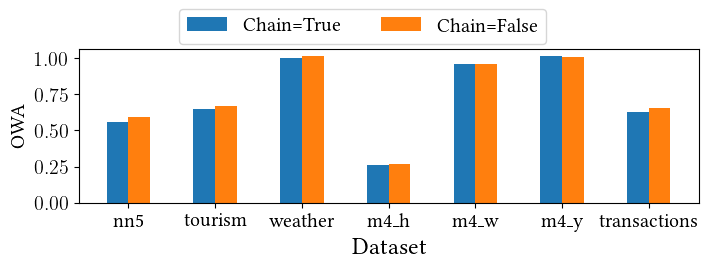

In [28]:
with open("results/ablation_chaining.pkl", "rb") as file:
    errors = pickle.load(file)
e_chaining_true = errors["SHIFT_chaining=True"]
e_chaining_false = errors["SHIFT_chaining=False"]
error_df = pd.DataFrame(columns=list(e_chaining_true.keys()))

error_df.loc["True"] = np.array(list(e_chaining_true.values()))[:,-1]
error_df.loc["False"] = np.array(list(e_chaining_false.values()))[:,-1]

r = np.arange(len(error_df.columns)) 
width = 0.25

plt.figure(figsize=(8,2))
plt.bar(r, error_df.loc["True"], color = "tab:blue", 
        width = width, label="Chain=True") 
plt.bar(r + width, error_df.loc["False"], color = "tab:orange", 
        width = width, label="Chain=False") 
plt.xticks(r+width/2,error_df.columns, fontsize="x-large")
plt.yticks(fontsize="x-large")
plt.legend(bbox_to_anchor=(0.07,1.12,0.7,0.2), ncol=2, fontsize="x-large")
plt.xlabel("Dataset", fontdict={"fontsize": "xx-large"})
plt.ylabel("OWA", fontdict={"fontsize": "x-large"})
# plt.savefig("plots/ablation_chaining.pdf", bbox_inches="tight")

print(error_df)

            nn5   tourism   weather      m4_h      m4_w      m4_y  \
True   0.558882  0.618578  0.981777  0.246905  0.890426  1.033729   
False  0.592357  0.671452  1.014096  0.266231  0.958166  1.010663   

       transactions  
True       0.631583  
False      0.657862  


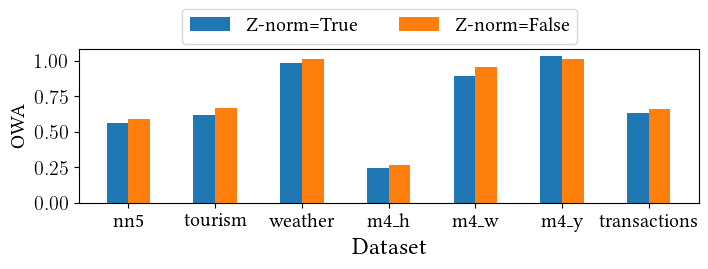

In [29]:
with open("results/ablation_z-norm.pkl", "rb") as file:
    errors = pickle.load(file)

z_norm_true = errors["SHIFT_z-norm=True"]
z_norm_false = errors["SHIFT_z-norm=False"]
error_df = pd.DataFrame(columns=list(z_norm_true.keys()))

error_df.loc["True"] = np.array(list(z_norm_true.values()))[:,-1]
error_df.loc["False"] = np.array(list(z_norm_false.values()))[:,-1]

r = np.arange(len(error_df.columns))
width = 0.25

plt.figure(figsize=(8,2))
plt.bar(r, error_df.loc["True"], color = "tab:blue", 
        width = width, label="Z-norm=True") 
plt.bar(r + width, error_df.loc["False"], color = "tab:orange", 
        width = width, label="Z-norm=False") 
plt.xticks(r+width/2,error_df.columns, fontsize="x-large")
plt.yticks(fontsize="x-large")
plt.legend(bbox_to_anchor=(0.07,1.12,0.75,0.2), ncol=2, fontsize="x-large")
plt.xlabel("Dataset", fontdict={"fontsize": "xx-large"})
plt.ylabel("OWA", fontdict={"fontsize": "x-large"})
# plt.savefig("plots/ablation_z_norm.pdf", bbox_inches="tight")

print(error_df)

# Synthetic data

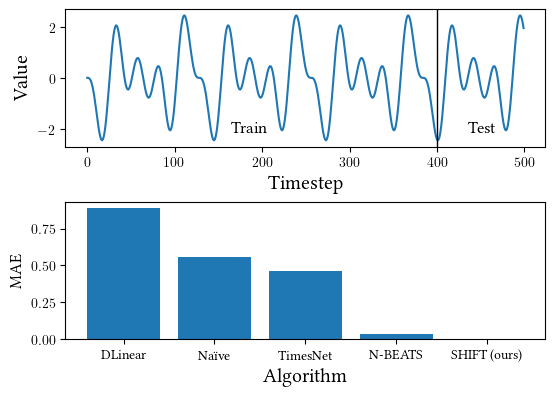

In [73]:
from basic_models import predict_naive, predict_dlinear, predict_nbeats, predict_timesnet
from data_wrangling import train_test_split
from evaluation import mae

def predict_dataset(dataset, k=False, chain=False, z=False):
    random_states = np.arange(1)

    errors = {}
    pred_dlinear, _ = predict_dlinear(dataset, random_states)
    errors["DLinear"] = mae(dataset["y_test"], pred_dlinear)
    pred_naive, _ = predict_naive(dataset)
    errors["Naïve"] = mae(dataset["y_test"], pred_naive)
    pred_nbeats, _ = predict_nbeats(dataset, random_states)
    errors["N-BEATS"] = mae(dataset["y_test"], pred_nbeats)
    pred_transformer, _ = predict_timesnet(dataset, 64, 64, random_states)
    errors["TimesNet"] = mae(dataset["y_test"], pred_transformer)

    # SHIFT requires non-flat data grouped by sample, here we only have one sample, so add one dimension
    for key,v in dataset.items():
        dataset[key] = [v]
    
    pred_shift, _ = predict_shift_ablation(dataset, k=k, chain=chain, z_normalization=z)
    errors["SHIFT (ours)"] = mae(dataset["y_test"], pred_shift)

    scores = np.array(list(errors.values()))
    algorithms = np.array(list(errors.keys()))
    return scores, algorithms

# Forecasting synthetic data

synthetic_data_length = 500

sine_data1 = np.arange(synthetic_data_length).astype(float)
sine_data1 *= np.pi
sine_data1 /= 64
sine_data1 = np.sin(sine_data1)

sine_data2 = np.arange(synthetic_data_length).astype(float)
sine_data2 *= np.pi
sine_data2 /= 32
sine_data2 = np.sin(sine_data2)

sine_data3 = np.arange(synthetic_data_length).astype(float)
sine_data3 *= np.pi / 16
sine_data3 = np.cos(sine_data3) * 2

data_merged = sine_data1 * sine_data3 - sine_data2

synthetic_dataset = train_test_split(data_merged, 5, 10, 0.6, 0.2, 1)
synthetic_dataset["is_multivariate"] = False

scores, algorithms = predict_dataset(synthetic_dataset)

sort_order = np.flip(np.argsort(scores))
scores = scores[sort_order]
algorithms = algorithms[sort_order]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))
plt.subplots_adjust(left=0.1, bottom=0.2, right=0.9, top=0.75, wspace=0.4, hspace=0.4)
axes[1].bar(x=algorithms, height=scores, color="tab:blue")
axes[1].set_xlabel("Algorithm", fontsize="x-large")
axes[1].set_ylabel("MAE", fontsize="large")

axes[0].plot(data_merged, color="tab:blue")
axes[0].set_xlabel("Timestep", fontsize="x-large")
axes[0].set_ylabel("Value", fontsize="x-large")
axes[0].axvline(int(0.8*synthetic_data_length), lw=1, color="black")
axes[0].text(165,-2.1, "Train", fontdict={"fontsize": "large"})
axes[0].text(435,-2.1, "Test", fontdict={"fontsize": "large"})

plt.savefig("plots/synthetic_demo.pdf", bbox_inches="tight")
plt.show()

# Scalability

In [15]:
with open("results_multivariate/benchmark_scalability.pkl", "rb") as file:
    res = pickle.load(file)
lengths = []
times_naive = []
times_kdtree = []
for length, times in res.items():
    lengths.append(int(float(length)))
    times_naive.append(times["SHIFT_naive_mean"])
    times_kdtree.append(times["SHIFT_kdtree_mean"])

In [69]:
(times_naive[-1] - times_kdtree[-1]) / times_naive[-1]

0.984150295921123

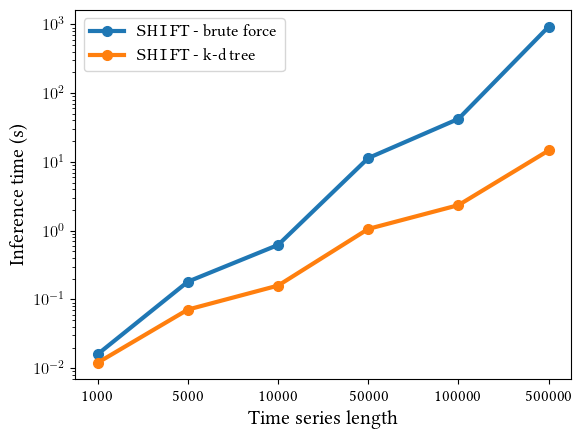

In [70]:
plt.plot(times_naive, linewidth=3, marker="o", markersize=7, label="\\texttt{SHIFT} - brute force")
plt.plot(times_kdtree, linewidth=3, marker="o", markersize=7, label="\\texttt{SHIFT} - k-d tree")
plt.yscale("log")
plt.yticks(fontsize="large")
plt.xticks(np.arange(len(lengths)),lengths, fontdict={"fontsize": "large"})
plt.ylabel("Inference time (s)", fontdict={"fontsize": "x-large"})
plt.xlabel("Time series length", fontdict={"fontsize": "x-large"})
plt.legend(fontsize="large")
plt.savefig("plots/scalability.pdf", bbox_inches="tight")